In [63]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_recall_curve
from tensorflow.keras.callbacks import EarlyStopping


In [57]:
data_pca = pd.read_csv('/content/pca_result.csv')

In [58]:
# variable objetivo (Attrition)
le = LabelEncoder()
data_pca['Attrition'] = le.fit_transform(data_pca['Attrition'])  # 'Yes' -> 1, 'No' -> 0

# Separar variables numericas de variable objetivo
X_pca = data_pca.drop(columns=['Attrition'])
y_pca = data_pca['Attrition']

#Particion aplicando SMOTE para balancear clases
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_pca, test_size=0.3, random_state=42)

# Aplicar SMOTE al conjunto de entrenamiento para balancear las clases
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Escalado de los conjuntos después de SMOTE
scaler = StandardScaler()
X_train_smote = scaler.fit_transform(X_train_smote)
X_test = scaler.transform(X_test)

In [84]:
# Se define la estructura de la red neuronal simple
model = Sequential()
model.add(Dense(64, input_shape=(X_train_smote.shape[1],), activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.5))  # Ajuste de dropout
model.add(Dense(32, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.3))  # Ajuste de dropout
model.add(Dense(16, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))  # Capa de salida con softmax para clasificación binaria

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#Se coloca early stopping para evitar sobre ajuste
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#Compilacion de la red
history = model.fit(X_train_smote, y_train_smote, epochs=70, batch_size=64, validation_split=0.3,
                    verbose=1, callbacks=[early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5912 - loss: 1.9316 - val_accuracy: 0.0566 - val_loss: 2.0791
Epoch 2/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6670 - loss: 1.7727 - val_accuracy: 0.0352 - val_loss: 1.9995
Epoch 3/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7113 - loss: 1.6255 - val_accuracy: 0.1016 - val_loss: 1.8492
Epoch 4/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7149 - loss: 1.5190 - val_accuracy: 0.2188 - val_loss: 1.7291
Epoch 5/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7534 - loss: 1.3708 - val_accuracy: 0.3672 - val_loss: 1.6108
Epoch 6/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7246 - loss: 1.3149 - val_accuracy: 0.6484 - val_loss: 1.4597
Epoch 7/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7880 - loss: 1.2065 - val_accuracy: 0.7422 - val_loss: 1.3660
Epoch 8/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7786 - loss: 1.1454 - val_accuracy: 0.8398 - val_loss

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


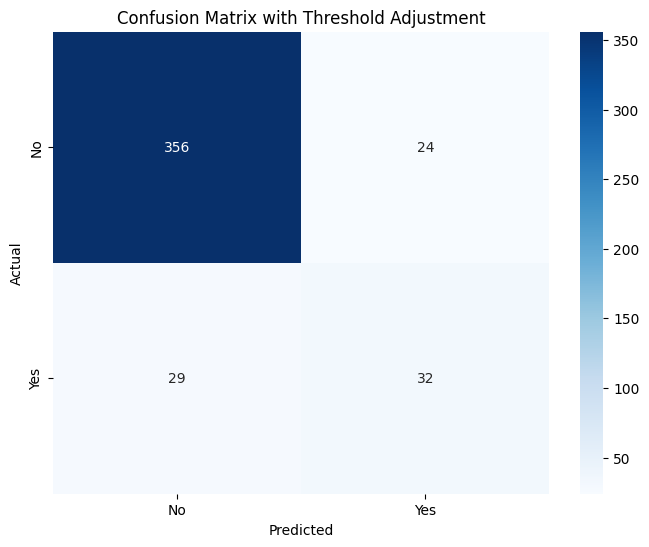

              precision    recall  f1-score   support

          No       0.92      0.94      0.93       380
         Yes       0.57      0.52      0.55        61

    accuracy                           0.88       441
   macro avg       0.75      0.73      0.74       441
weighted avg       0.88      0.88      0.88       441



In [85]:
# Predicción del modelo con umbral
y_pred_prob = model.predict(X_test)[:, 1]  # Probabilidad de la clase 'Yes'
y_pred_adjusted = (y_pred_prob >= 0.5).astype(int)  # Ajuste del umbral a 0.5

# Matriz de confusión y reporte de clasificación con el umbral ajustado
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Threshold Adjustment')
plt.show()

print(classification_report(y_test, y_pred_adjusted, target_names=['No', 'Yes']))

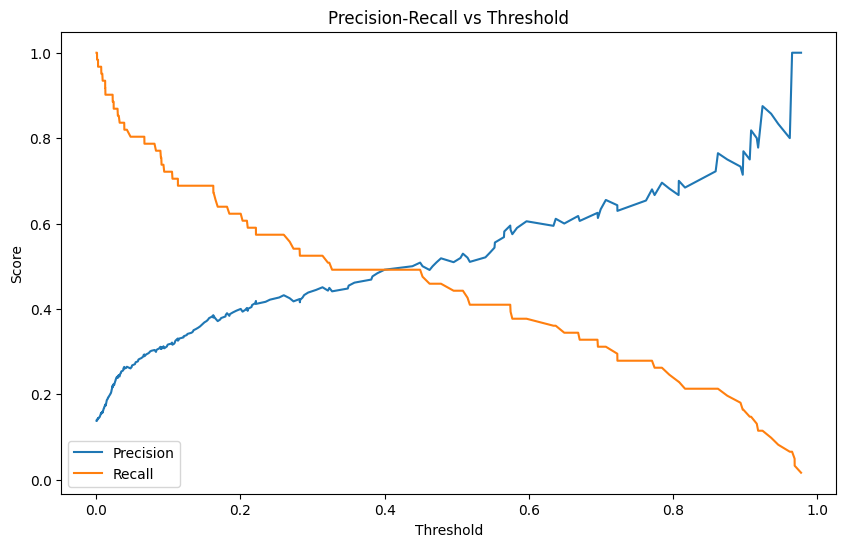

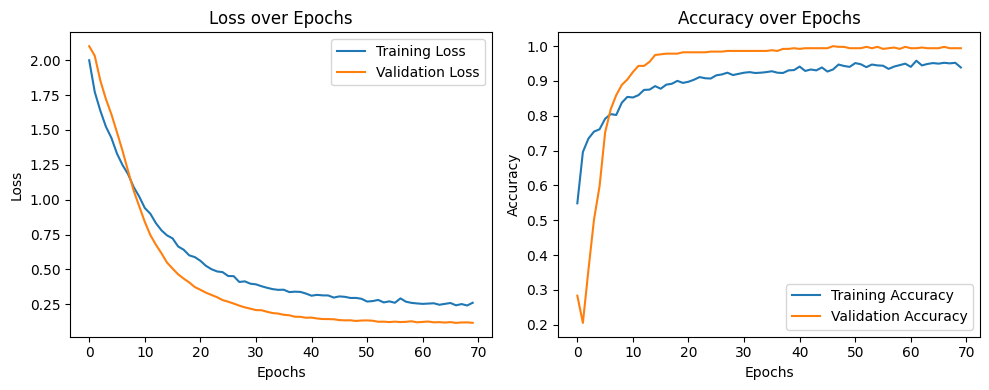

In [62]:
# Gráfica Precision-Recall para evaluar el umbral óptimo
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision-Recall vs Threshold")
plt.show()


# Gráfica de pérdida
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

# Gráfica de precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.tight_layout()
plt.show()